Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


Text(3975, 0.36751908856118704, "Class ['N']")

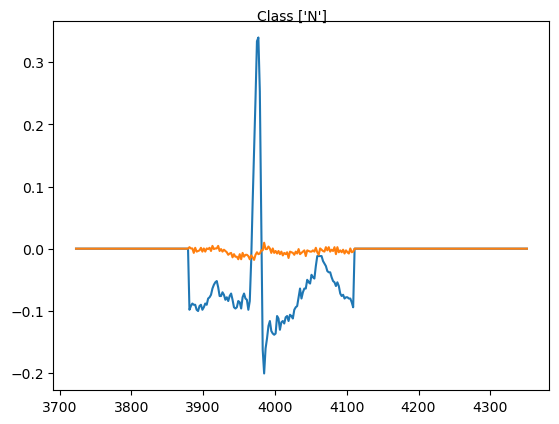

In [30]:
import wfdb                            # Package for loading the ecg and annotation
from wfdb import rdrecord, rdann, processing
from sklearn import preprocessing
import numpy as np

import matplotlib.pyplot as plt

data = '..\\..\\data\\.mitdb_original_data\\'
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']
# Non Beat Symbols
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']

# Abnormal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

# Classification based on AAMI
AAMI = ['N','L','R','B','A','a','j','S','V','r','F','e','j','n','E','f','/','Q','?']


normal = ['N']
dic = {'N': ['N', 'L', 'R', 'B'],
       'S': ['A', 'a', 'j', 'S', 'e', 'j', 'n'],  # <---- There are 2 small "j"s. Should one of them be "J"??? There is also no small "n"
       'V': ['V', 'r', 'E'],
       'F': ['F'],
       'Q': ['Q', '?', 'f', '/'],
      }

dic = {0: ['N', 'L', 'R', 'B'],
       1: ['A', 'a', 'j', 'S', 'e', 'j', 'n'],  # <---- There are 2 small "j"s. Should one of them be "J"??? There is also no small "n"
       2: ['V', 'r', 'E'],
       3: ['F'],
       4: ['Q', '?', 'f', '/'],
      }


record_length = 630
percent_left = 0.4
percent_right = 1-percent_left
peak_pos = np.int32(record_length * 0.4)
max_length_left = np.int32(record_length * percent_left)
max_length_right = np.int32(record_length * percent_right)


record_number = '200'
record = wfdb.rdrecord(data+record_number,smooth_frames=True)
l2 = preprocessing.scale(np.nan_to_num(record.p_signal[:,0]))
v5 = preprocessing.scale(np.nan_to_num(record.p_signal[:,1]))
l2 = l2 / np.max(l2)
v5 = v5 / np.max(v5)

area = 4000
search_area = 750
insize=360
qrs = processing.XQRS(sig = l2[area-search_area:area+search_area],fs = 360)
qrs.detect()
peaks = qrs.qrs_inds
i_closest_peak = np.abs(peaks-search_area).argmin()

peak_l = peaks[i_closest_peak-1] + area - search_area
peak = peaks[i_closest_peak] + area - search_area
peak_r = peaks[i_closest_peak+1] + area - search_area

# 40% des Signals vor dem Peak
dleft = np.int32((peak - peak_l) * percent_left)
if dleft > max_length_left:  dleft = max_length_left

# 60% des Signals nach dem Peak
dright = np.int32((peak_r - peak) * percent_right)
if dright > max_length_right: dright = max_length_right

start = np.int32(peak - dleft)
end = np.int32(peak + dright)

ann = wfdb.rdann(data+record_number,extension='atr', sampfrom = start, sampto = end,
                         return_label_elements=['symbol'])
annsymbol =ann.symbol

# Stellt sicher, dass sich der Peak immer an der selben Position befindet!
l2_sig = np.zeros(record_length)
l2_sig[peak_pos-dleft:peak_pos] = l2[start:peak]
l2_sig[peak_pos:peak_pos+dright] = l2[peak:end]
l2_sig = l2_sig[::2]
xaxis = np.arange(peak-int(record_length*percent_left), peak + int(record_length*percent_right))[::2]

# Stellt sicher, dass sich der Peak immer an der selben Position befindet!
v5_sig = np.zeros(record_length)
v5_sig[peak_pos-dleft:peak_pos] = v5[start:peak]
v5_sig[peak_pos:peak_pos+dright] = v5[peak:end]
v5_sig = v5_sig[::2]

plt.plot(xaxis, l2_sig)
plt.plot(xaxis, v5_sig)
plt.text(peak, l2[peak]*1.1, f"Class {annsymbol}")


In [42]:
from tensorflow.keras.models import load_model

model = load_model("..\\..\\models\\combined_cnn1_bs256_k7_noweights.keras", compile=False)
prediction = model.predict([np.atleast_2d(l2_sig), np.atleast_2d(v5_sig)])

text = [f"Class {i}: {np.round(prediction[0, i],3)} \n" for i in range(5)]
print(text)


1/1 [==============================] - 0s 103ms/step
['Class 0: 1.0 \n', 'Class 1: 0.0 \n', 'Class 2: 0.0 \n', 'Class 3: 0.0 \n', 'Class 4: 0.0 \n']


In [43]:
dic = {'N': ['N', 'L', 'R', 'B'],
       'S': ['A', 'a', 'j', 'S', 'e', 'j', 'n'],  # <---- There are 2 small "j"s. Should one of them be "J"??? There is also no small "n"
       'V': ['V', 'r', 'E'],
       'F': ['F'],
       'Q': ['Q', '?', 'f', '/'],
      }

for a, b in dic.items():
    print(a)
    print(b)

N
['N', 'L', 'R', 'B']
S
['A', 'a', 'j', 'S', 'e', 'j', 'n']
V
['V', 'r', 'E']
F
['F']
Q
['Q', '?', 'f', '/']


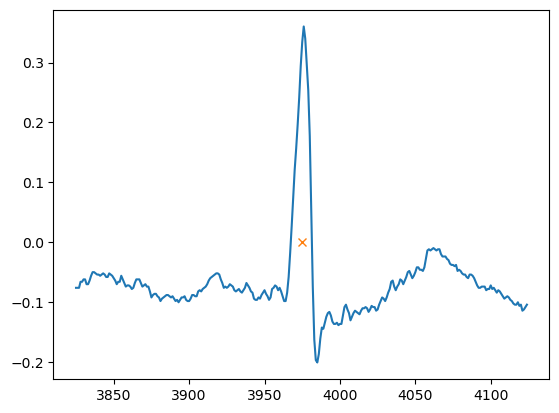

In [15]:
index_peak
l2[index_peak-10:index_peak+10].max()

plt.plot(np.arange(index_peak-150, index_peak+150),l2[index_peak-150:index_peak+150])
plt.plot(index_peak, 0, 'x')

In [14]:
area = 4000
qrs = processing.XQRS(sig = l2[area-search_area:area+search_area],fs = 360)
qrs.detect()
peaks = qrs.qrs_inds
closest_peak = peaks[np.abs(peaks-search_area).argmin()]
index_peak = area + closest_peak - search_area

index_peak

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


3975

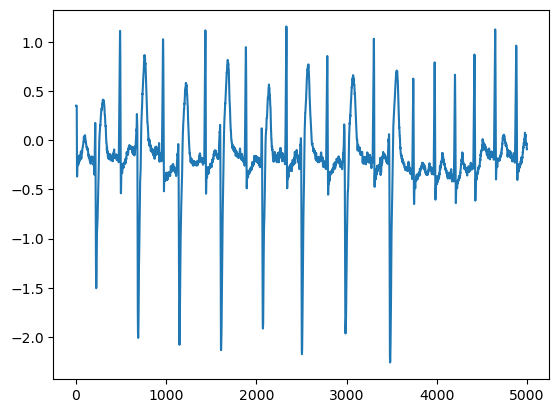

In [2]:

plt.plot(record.p_signal[:5000,0])

ann = wfdb.rdann(data+record_number,extension='atr', sampfrom = 0, sampto = 5000,
                         return_label_elements=['symbol'])
annsymbol =ann.symbol
ann